In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from preprocessing import load_loan_prepr

In [2]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('balanced_accuracy'), cv=StratifiedKFold())
    clf.fit(X_train, y_train)

    return clf

# Calculates the per-class accuracy given predicted and true output labels.
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

# Prints a summary of performance metrics given predicted and true output labels.
def print_metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    print(f'F1 = {f1}')
    print(f'Accuracy = {acc}')
    print(f'\tclass 0: {acc0}')
    print(f'\tclass 1: {acc1}')

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy ({}) = {}".format(model_name, bal_acc))
    print_metrics(y_pred, y_test)

In [3]:
X, y, feature_names = load_loan_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# KNN classifier

In [4]:
model_name = "k-nearest neighbors"
parameters = {'n_neighbors': np.arange(1, 307), 'weights': ('uniform', 'distance')}
kNN = KNeighborsClassifier()

clf = find_best_model(kNN, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

clf.best_estimator_

Balanced accuracy (k-nearest neighbors) = 0.6621204323211528
F1 = 0.8413793103448275
Accuracy = 0.7604166666666666
	class 0: 0.41379310344827586
	class 1: 0.9104477611940298


KNeighborsClassifier()

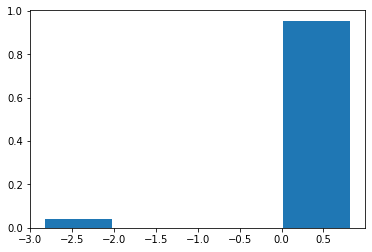

In [5]:
model = clf.best_estimator_

idx = 9
categorical = True

if categorical:
    values = np.unique(X[:,idx])
else:
    values = np.linspace(np.min(X[:,idx]), np.max(X[:,idx]), len(X))

PDP = list()

for value in values:
    X_copy = np.copy(X)
    X_copy[:,idx] = value
    predictions = model.predict(X_copy)
    PDP.append(np.mean(predictions))

if not categorical:
    plt.plot(values, PDP)
else:
    plt.bar(values, PDP)

# Decision tree classifier

In [6]:
model_name = "decision tree classifier"
parameters = {'criterion': ('gini', 'entropy'), 'min_samples_split': np.arange(2, 307)}
tr = DecisionTreeClassifier(random_state=seed)

clf = find_best_model(tr, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

clf.best_estimator_

Balanced accuracy (decision tree classifier) = 0.6374163664436439
F1 = 0.8275862068965517
Accuracy = 0.7395833333333334
	class 0: 0.3793103448275862
	class 1: 0.8955223880597015


DecisionTreeClassifier(min_samples_split=49, random_state=3012)

<AxesSubplot:>

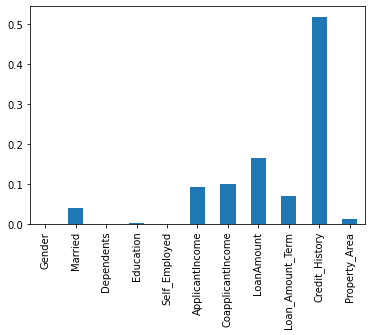

In [7]:
model = clf.best_estimator_
model.feature_importances_
df = pd.Series(data=model.feature_importances_, index=feature_names)
df.plot.bar()

# Support vector classifier

In [8]:
model_name = "support vector classifier"
parameters = {'C': np.geomspace(0.0001, 100, 61)}
svc = SVC(kernel="linear")

clf = find_best_model(svc, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

clf.best_estimator_

Balanced accuracy (support vector classifier) = 0.6994338651569737
F1 = 0.88
Accuracy = 0.8125
	class 0: 0.41379310344827586
	class 1: 0.9850746268656716


SVC(C=0.003981071705534973, kernel='linear')

<AxesSubplot:>

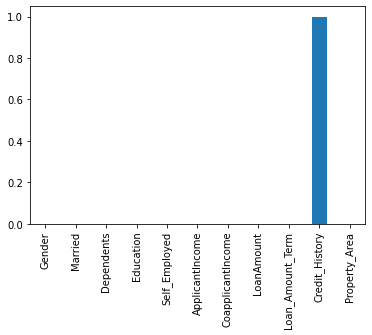

In [9]:
model = clf.best_estimator_
df = pd.Series(data=np.abs(model.coef_[0]) / np.sum(np.abs(model.coef_[0])), index=feature_names)
df.plot.bar()

In [10]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

pdp, axes = partial_dependence(model, X, [1, 1], method="brute", percentiles=(0.0, 1.0))
print(pdp)
pdp, axes = partial_dependence(model, X, [2, 2], method="brute", percentiles=(0.0, 1.0))
print(pdp)

[[[0.79029255 0.79025329]
  [0.79029255 0.79025329]]]
[[[0.79026684 0.79026719 0.79026755 0.79026791]
  [0.79026684 0.79026719 0.79026755 0.79026791]
  [0.79026684 0.79026719 0.79026755 0.79026791]
  [0.79026684 0.79026719 0.79026755 0.79026791]]]
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/inspection/_partial_dependence.py:523: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/inspection/_partial_dependence.py:523: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  FutureWarning,


[-1.68774224e+00 -1.58826976e+00 -1.48879728e+00 -1.47636323e+00
 -1.42662699e+00 -1.36445669e+00 -1.35202263e+00 -1.30228639e+00
 -1.25255016e+00 -1.24011610e+00 -1.22768204e+00 -1.21524798e+00
 -1.20281392e+00 -1.17794580e+00 -1.14064362e+00 -1.12820956e+00
 -1.11577550e+00 -1.10334144e+00 -1.06603926e+00 -1.05360521e+00
 -1.02873709e+00 -1.01630303e+00 -9.91434908e-01 -9.79000849e-01
 -9.66566789e-01 -9.29264611e-01 -9.16830552e-01 -8.91962433e-01
 -8.79528373e-01 -8.67094314e-01 -8.54660255e-01 -8.29792136e-01
 -8.04924017e-01 -7.92489958e-01 -7.67621839e-01 -7.55187779e-01
 -7.30319661e-01 -7.17885601e-01 -7.05451542e-01 -6.93017482e-01
 -6.80583423e-01 -6.43281245e-01 -6.30847185e-01 -6.18413126e-01
 -6.05979066e-01 -5.93545007e-01 -5.81110948e-01 -5.68676888e-01
 -5.56242829e-01 -5.43808769e-01 -5.31374710e-01 -5.18940650e-01
 -5.06506591e-01 -4.94072532e-01 -4.81638472e-01 -4.69204413e-01
 -4.56770353e-01 -4.44336294e-01 -4.31902235e-01 -4.19468175e-01
 -4.07034116e-01 -3.94600

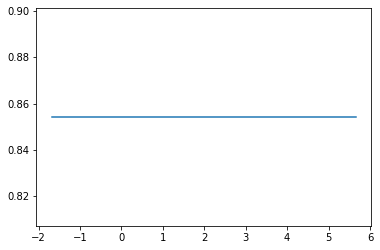

In [11]:
unique = np.unique(X[:,7])
PDP = list()
for value in unique:
    X_copy = np.copy(X)
    X_copy[:,7] = value
    predictions = model.predict(X_copy)
    PDP.append(np.mean(predictions))

print(unique)
print(PDP)
plt.plot(unique, PDP)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5161fece-8ef6-4825-9ea6-16ebba884483' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>